# Results of Edge Detection Benchmark and Speedup

By: Anshul Srivastava

## Serial Experiment

I compiled the serial code on the MSU HPCC. I was using an AMD-v20 development node to run this project. I compiled the code using the following commands:

```
make
make test
```

I ran the code 10 times by making a bash script called `serial_benchmark.sh` which ran the code 10 times, timed it, and the returned the average runtime for the serial code. I obtained the following results while running the script on the cube image:

```bash
#!/bin/bash

runs=10
total=0

for i in $(seq 1 $runs); do
    echo "Run #$i"
    runtime=$( /usr/bin/time -f "%e" make test_serial 2>&1 | tail -n 1)
    echo "Runtime: $runtime seconds"
    total=$(echo "$total + $runtime" | bc)
done

average=$(echo "$total / $runs" | bc -l)
echo "Average Runtime: $average" 
```

Average Runtime: 0.221 seconds

## Code Optimization

As laid out in the HW notebook, I started out by trying different compiler optimizations. However, I noticed that the cube image, and the sparty image did not have enough data in it to really see the difference between each optimization method. I then switched to the `earth.png` file, which better displays the effects of each optimization strategy.

* Compiler Optimization: O1, O2, and O3
* Reorder the loops in the `main_process.c` file. Loop over the rows in the outer and over the columns in the inner loops now.

Below is a graph showing the average runtime using each optimization strategy.

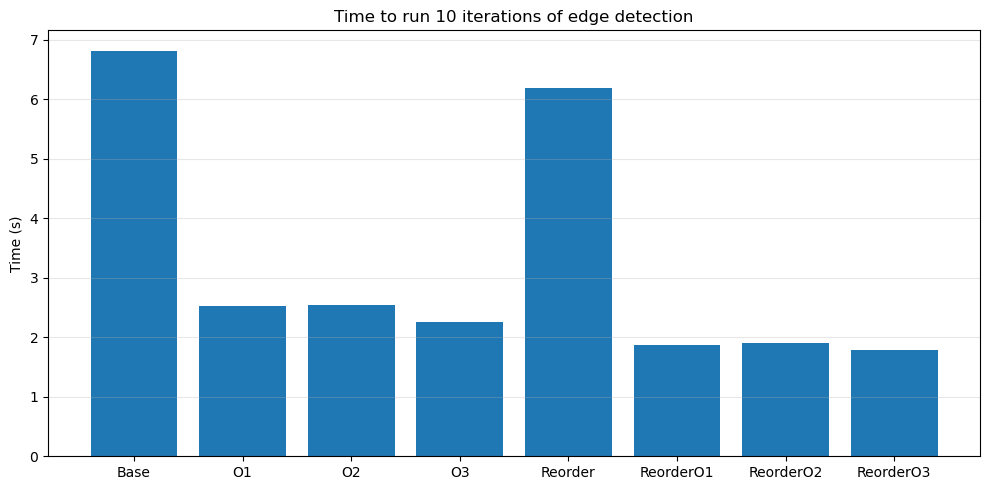

In [2]:
import matplotlib.pyplot as plt

strats = ['Base', 'O1', 'O2', 'O3', 'Reorder', 'ReorderO1', 'ReorderO2', 'ReorderO3']
times = [6.817, 2.532, 2.543, 2.264, 6.188, 1.867, 1.910, 1.782]

plt.figure(figsize=(10, 5))
plt.bar(strats, times)
plt.ylabel('Time (s)')
plt.title('Time to run 10 iterations of edge detection')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

For the base serial code, using an `-O3` compiler optimization proved to give highest speed-up. This was a little surprising, since most online resources recommend using `-O2` for most things, but I guess the code we have benefits from the extra optimization provided by `-O3`. 

Then, for the optimized and reordered code, we observed a similar trend. Using `-O3` gave the biggest boost. However, I was surprised at how little effect reordering the loops had in our case. I am not sure about the reason for this - maybe our data is just not large enough for this effect to accumulate?

## OpenMP Speedup

I started off with the optimized serial code, where we loop over the rows in the outer loops and the columns in the inner loops. I read online that C optimizes its cache-lines using row major order. The obvious approach from here was to introduce threading before each filter using `#pragma omp parallel for`. Since the end result of each loop iteration is just updating the current pixel value, we do not need any reduction operators - there is no shared sum. Each thread simply operates on its pixel. The rest of the time was dedicated to finding the best scheduling strategy. Here is a list of strategies I looked at (formatted as *strategy[chunk_size]*):

* `static(10)`
* `static(20)`
* `dynamic(10)`
* `dynamic(20)`
* `guided(10)`
* `guided(20)`
* `auto`
* `collapse (2) auto`

Here is a graph showing the average runtime using each scheduling strategy.

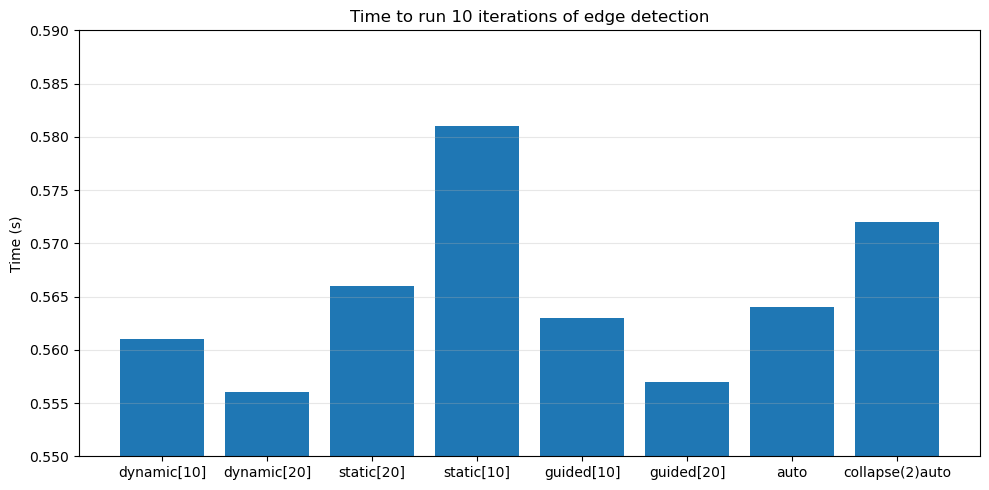

In [6]:
strats = ['dynamic[10]', 'dynamic[20]', 'static[20]', 'static[10]', 'guided[10]', 'guided[20]', 'auto', 'collapse(2)auto']
times = [0.561, 0.556, 0.566, 0.581, 0.563, 0.557, 0.564, 0.572]

plt.figure(figsize=(10, 5))
plt.bar(strats, times)
plt.ylabel('Time (s)')
plt.ylim(0.55, 0.59)   
plt.title('Time to run 10 iterations of edge detection')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Concluding Discussion

The biggest hurdle was very elementary - choosing the right png file to see the effect of parallelization. I kept using the `sparty.png` file to run all benchmark efforts. I kept getting similar runtimes for all three approaches - serial, optimized, and parallelized. It took me a while to figure out that the file is just not complext enough for the optimization effects to kick in. Once I choose the `earth.png` file, things were easier from then.

Using compiler optimizations is something I was introduced to early in this class. Implementing those was easy, as a result. The row major preference for C cache lines was someting I was not aware of, but the hint given in the homework files was a nice starting point. Online resources helped me figure that part out - switching the order of the loops was fairly simple.

As for applying parallelization, the structure of the code helped out a bunch. Like I mentioned before, the lack of any shared sums/variables inside the loops made the porcess much easier. All I had to do was wrap each loop in a `#pragma omp parallel for` bracket. As expected, the effect of parallelization was noticed as the image file became more visible. Each method - serial, optimized, and parallel give the same outputs!

Here are what outputs for each image look like:

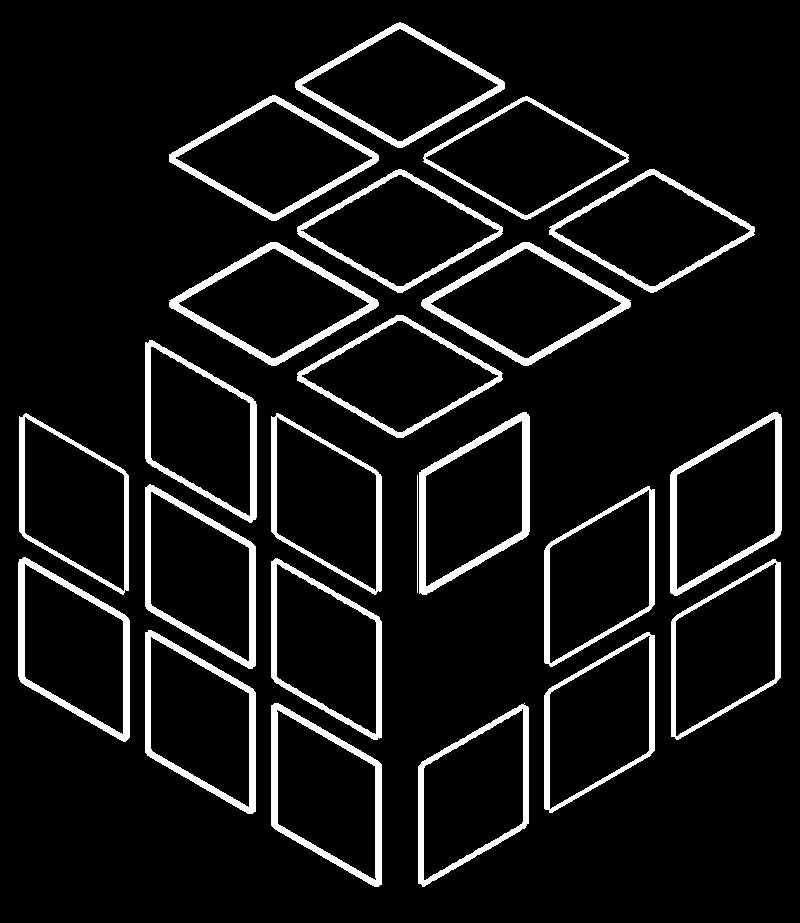

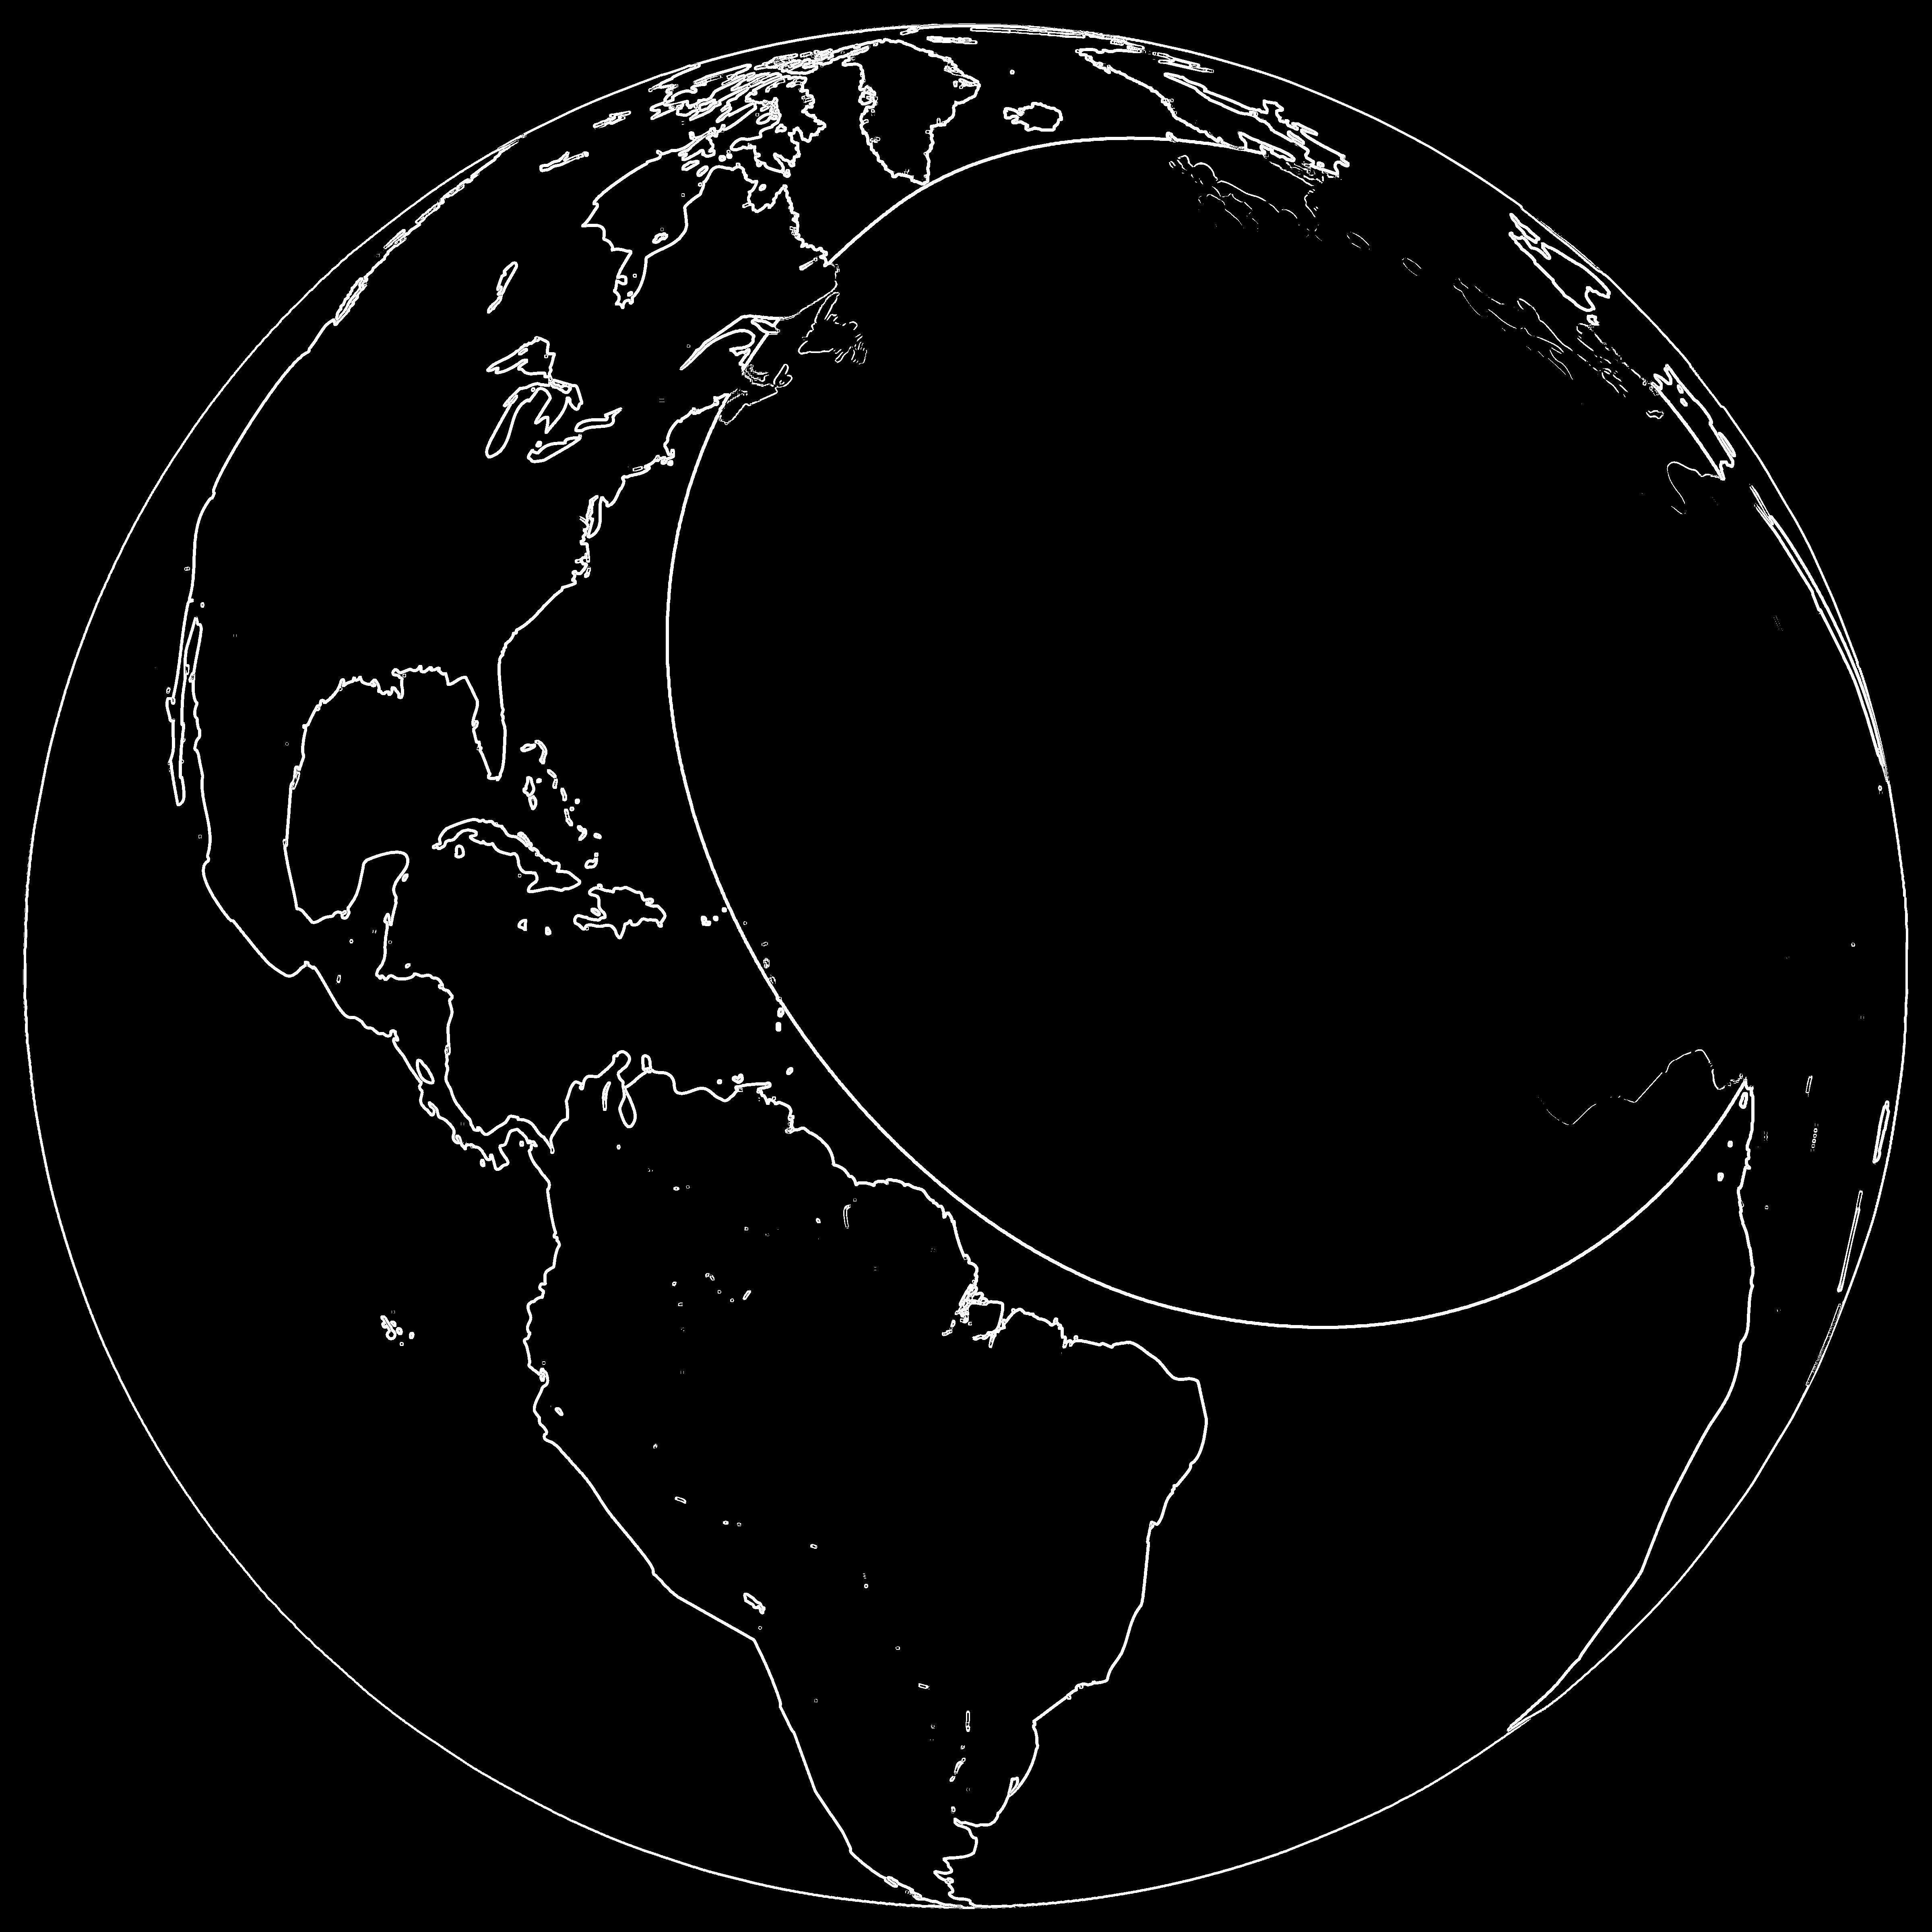

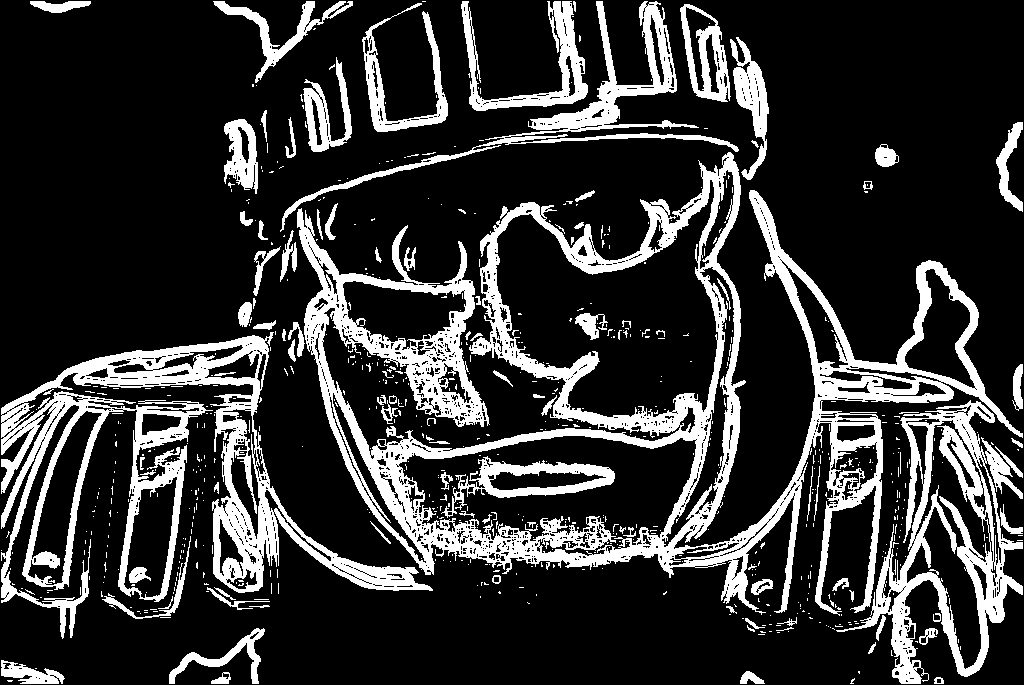

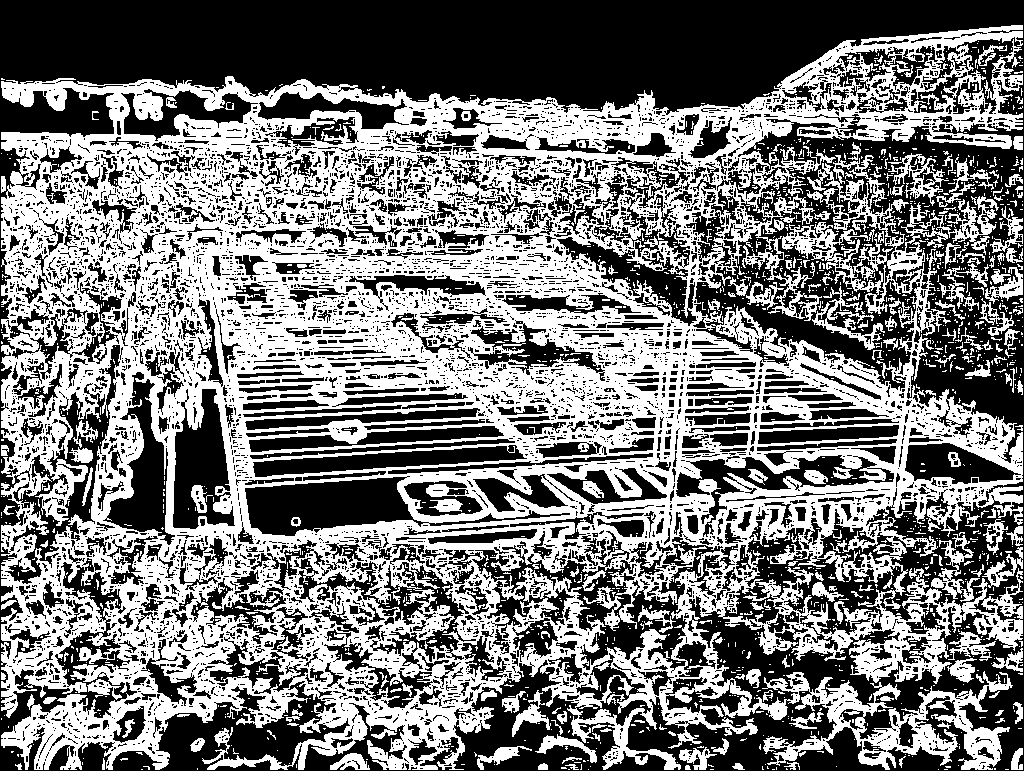

----